In [1]:
# install and restart run time 
!pip install -U albumentations
!pip install ttach

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.0)


### Clone from repository

In [2]:
!git clone "https://github.com/jacobgil/pytorch-grad-cam.git"

!git clone "https://github.com/vvshankar78/DeepLearning.git"

fatal: destination path 'pytorch-grad-cam' already exists and is not an empty directory.
fatal: destination path 'DeepLearning' already exists and is not an empty directory.


In [3]:
import sys, os

my_path = 'DeepLearning/Extensive VisionAI-EVA6/08_Resnet'
sys.path.append(my_path)
# os.listdir(my_path)

my_path_cam = '/content/pytorch-grad-cam'
sys.path.append(my_path_cam)

In [4]:
# # load Google Driver
# from google.colab import drive
# import sys, os
# drive.mount('/content/drive')
# my_path = '/content/drive/MyDrive/Computer Vision/Extensive VisionAI-EVA6/08_Resnet'
# sys.path.append(my_path)
# os.listdir(my_path)

In [5]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

In [7]:
# from model import Net2
from models import Resnet
from models import my_model
from train import train
from test1 import test
from config import ModelConfig
from utils import *
from data.data_engine import DataEngine

In [8]:
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import show_cam_on_image, \
                                         deprocess_image, \
                                         preprocess_image




In [9]:
# View model config
args = ModelConfig()
args.dropout_value = 0.0
args.print_config()

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout_value': 0.0,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1}


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


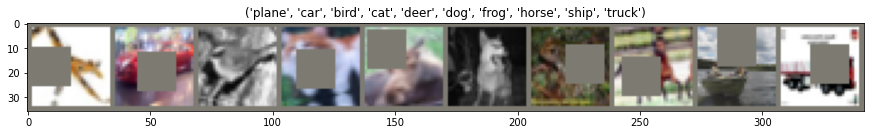

In [10]:
data = DataEngine(args)
data.show_samples()

In [11]:

train_loader = data.train_loader

test_loader = data.test_loader

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

#dict to store model loss and accuracy parameters
history = {}

CUDA Available? True


In [12]:
net = Resnet.ResNet18().to(device)

In [13]:
# temp = my_model.Net2(args).to(device)
# summary(temp, 
#         (3, 32, 32),)

In [14]:
# Input parameters for the model
EPOCHS = 10
l1_decay=0.000
l2_decay=0.0
#norm_type = "BN"
#num_groups=2
#input_img_size=(1, 28, 28)


# Run model for first 20 epochs with high rate, and half it thereafter
# model = Net2(args).to(device)
model = net
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", optimizer.param_groups[0]['lr'])
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, criterion, classes, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = 'Resnet18'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
DeepLearning/Extensive VisionAI-EVA6/08_Resnet/models/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
Loss=2.0562872886657715 Batch_id=781 Accuracy=42.02: 100%|██████████| 782/782 [00:35<00:00, 22.00it/s]

length of Average loss 782, length of Average accuracy 782

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0215, Accuracy: 5147/10000 (51.47%)

EPOCH: 2


Loss=0.8770304918289185 Batch_id=781 Accuracy=58.56: 100%|██████████| 782/782 [00:35<00:00, 22.01it/s]

length of Average loss 1564, length of Average accuracy 1564

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0136, Accuracy: 6931/10000 (69.31%)

EPOCH: 3


Loss=0.8781951069831848 Batch_id=781 Accuracy=65.61: 100%|██████████| 782/782 [00:35<00:00, 22.14it/s]

length of Average loss 2346, length of Average accuracy 2346

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0123, Accuracy: 7321/10000 (73.21%)

EPOCH: 4


Loss=0.5781930685043335 Batch_id=781 Accuracy=69.06: 100%|██████████| 782/782 [00:35<00:00, 22.19it/s]

length of Average loss 3128, length of Average accuracy 3128

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0118, Accuracy: 7514/10000 (75.14%)

EPOCH: 5


Loss=0.6140118837356567 Batch_id=781 Accuracy=71.83: 100%|██████████| 782/782 [00:35<00:00, 22.27it/s]

length of Average loss 3910, length of Average accuracy 3910

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0104, Accuracy: 7791/10000 (77.91%)

EPOCH: 6


Loss=0.44918569922447205 Batch_id=781 Accuracy=74.12: 100%|██████████| 782/782 [00:35<00:00, 21.96it/s]

length of Average loss 4692, length of Average accuracy 4692

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0081, Accuracy: 8234/10000 (82.34%)

EPOCH: 7


Loss=0.8678889274597168 Batch_id=781 Accuracy=75.61: 100%|██████████| 782/782 [00:35<00:00, 22.05it/s]

length of Average loss 5474, length of Average accuracy 5474

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0086, Accuracy: 8200/10000 (82.00%)

EPOCH: 8


Loss=0.5260446667671204 Batch_id=781 Accuracy=76.97: 100%|██████████| 782/782 [00:35<00:00, 21.80it/s]

length of Average loss 6256, length of Average accuracy 6256

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0079, Accuracy: 8296/10000 (82.96%)

EPOCH: 9


Loss=0.7752307653427124 Batch_id=781 Accuracy=77.75: 100%|██████████| 782/782 [00:35<00:00, 21.99it/s]

length of Average loss 7038, length of Average accuracy 7038

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0081, Accuracy: 8265/10000 (82.65%)

EPOCH: 10


Loss=0.8884828686714172 Batch_id=781 Accuracy=79.06: 100%|██████████| 782/782 [00:35<00:00, 21.87it/s]

length of Average loss 7820, length of Average accuracy 7820

learning rate 0.01


Test set: Average loss: 0.0073, Accuracy: 8448/10000 (84.48%)



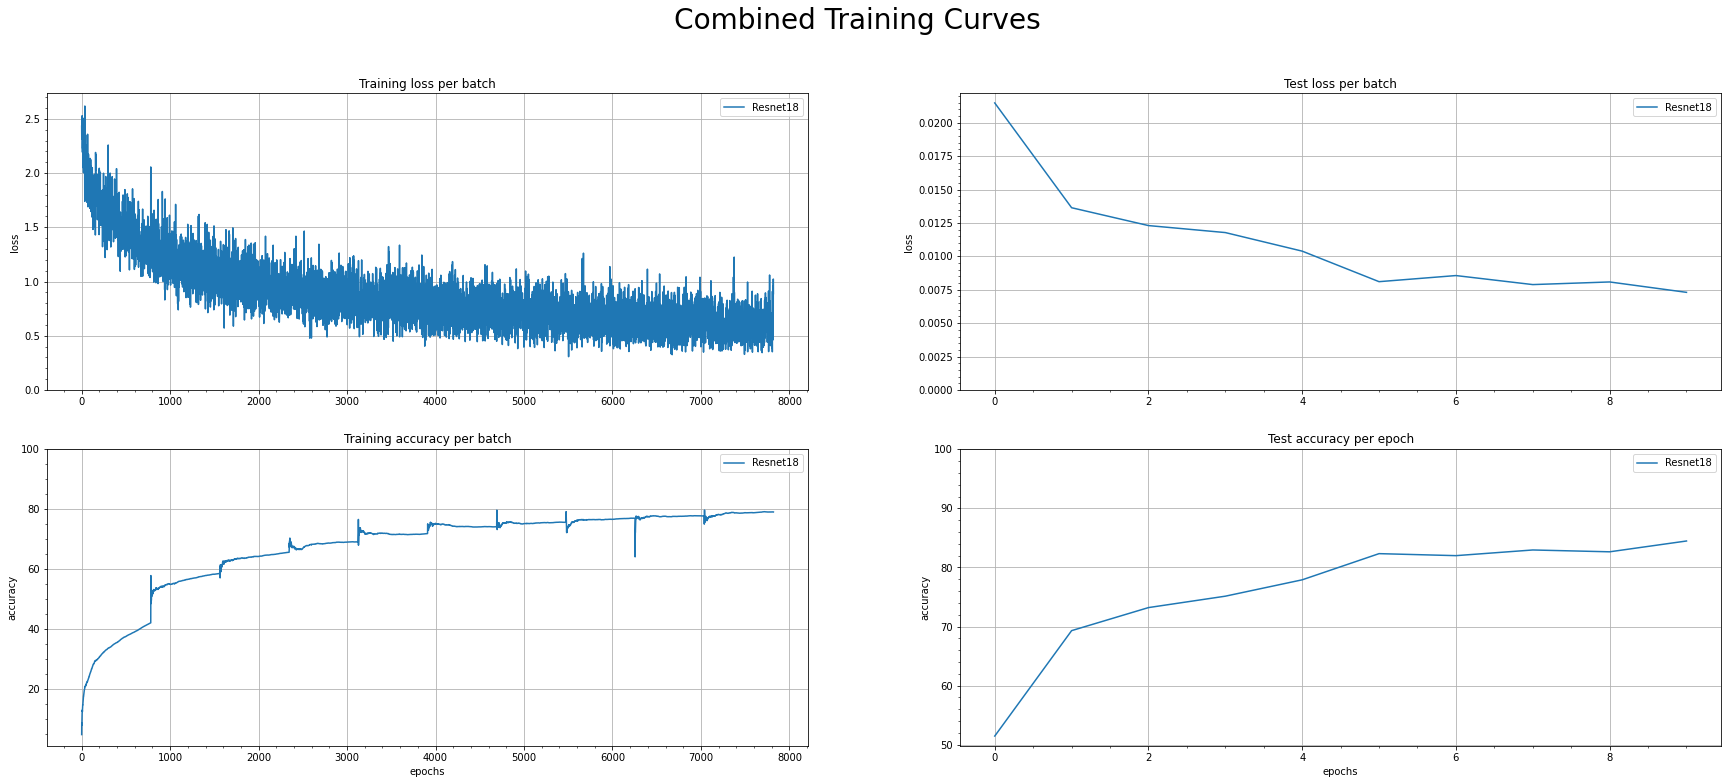

In [15]:
training_curves(history)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
DeepLearning/Extensive VisionAI-EVA6/08_Resnet/models/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


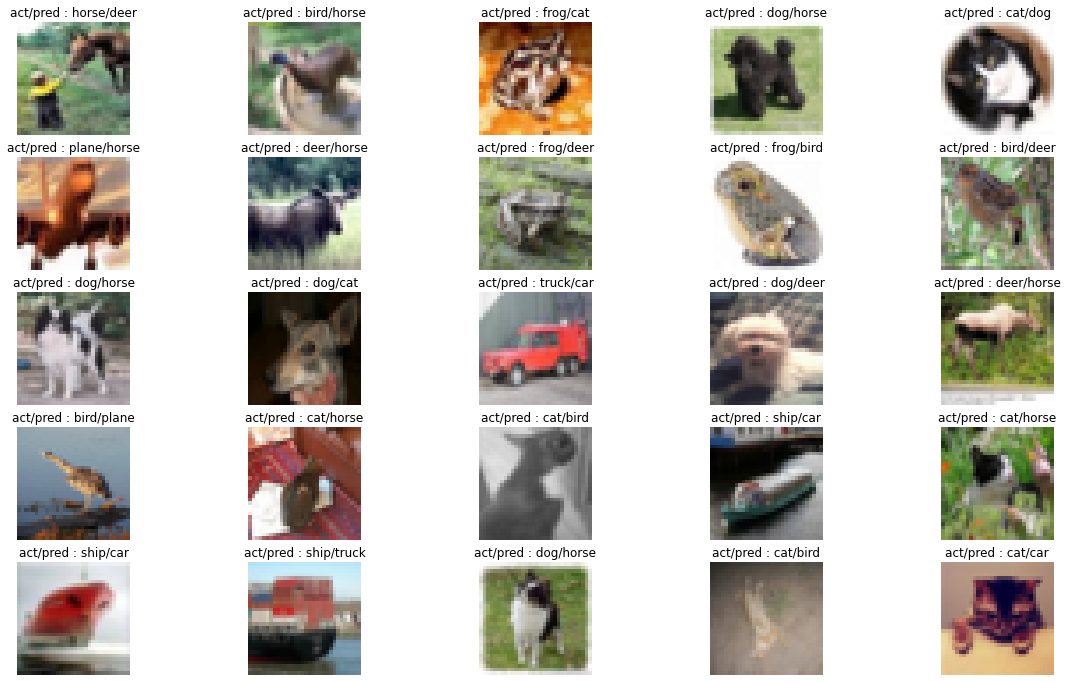

In [16]:
def imshow(img):
	img = denormalize(img)
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))
	plt.grid(b=None)
	return img

#classes = data.classes

model.eval()

figure = plt.figure(figsize=(20, 12))
num_of_images = 25
index = 1

misclass_img_list = []
misclass_img_category = []
untrans_img=[]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(
            device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        act = target.view_as(pred)
        # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
        bool_vec = ~pred.eq(act)

        # now extract the index number from the tensor which has 'true'
        idx = list(
            np.where(bool_vec.cpu().numpy())[0])

        if idx:  # if not a blank list
            idx_list = idx
            # print(data[idx_list[0]].shape)
            if index < num_of_images+1:
                plt.subplot(5, 5, index)
                plt.axis('off')
                titl = 'act/pred : ' + \
                    str(classes[target[idx[0]].cpu().item(
                    )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
                # prints the 1st index of each batch.
            
                img = data[idx[0]].cpu()
                untrans_img.append(img)
                image = imshow(img)
                misclass_img_list.append(image)
                misclass_img_category.append(target[idx[0]].cpu().item())
                                  


                plt.title(titl)
                index += 1



In [17]:
mis_img_name_list = []

for i in range(len(misclass_img_list)):
  # img_name = 'images/'+'mis_img'+str(i+1)+'.jpeg'
  img_name = 'mis_img'+str(i+1)+'.jpeg'
  mis_img_name_list.append(img_name)
  image = (255*torch.swapaxes(misclass_img_list[i], 0, 2))
  image = torch.swapaxes(image, 0, 1)
  image = image.type(torch.uint8).cpu().numpy()
  #print(image.shape)
  matplotlib.image.imsave(img_name, image)
  # print(img_name)

### The Receptive Field of 7x7 is achieved in the middle of layer1, so we keep that as first

In [20]:
target_layer0 = model.layer1[0]    #RF 7x7
target_layer1 = model.layer1[-1]   #rest are the end of respective layers
target_layer2 = model.layer2[-1]
target_layer3 = model.layer3[-1]
target_layer4 = model.layer4[-1]

visualization = []   #store all the grad cam images here
rgb_img_list = []

missclassified_count = 25

for i in range(0, missclassified_count-1):
    # visualization = [] 
    
    # image_path = 'images/mis_img' + str(i+1) + '.jpeg'
    image_path = 'mis_img' + str(i+1) + '.jpeg'
    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    #rgb_img = cv2.resize(rgb_img, (224, 224))    #uncomment this to scale to 224x224
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    rgb_img_list.append(rgb_img)
    
    #we change it to correct category for each image
    #'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
    # 0,       1,     2,      3,     4,      5,     6,      7,       8,      9

    target_category = misclass_img_category[i]
    visualization.append(rgb_img)

    for layer in [target_layer0, target_layer1, target_layer2, target_layer3, target_layer4]:
        cam = GradCAM(model=model, target_layer=layer, use_cuda=cuda)
        grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
        grayscale_cam = grayscale_cam[0, :]
        
        visualization.append(show_cam_on_image(rgb_img, grayscale_cam))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
DeepLearning/Extensive VisionAI-EVA6/08_Resnet/models/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


In [21]:

def show_image(visualization, start_image):

  plt.rcParams['figure.figsize'] = [24, 12]
  plt.figure(1)
  cnt=1
  layer_no=0
  # start_image = 48
  for i in range(1, 25):
      # plt.subplot(int(len(visualization)/6), 6, i)
      plt.subplot(4, 6, i)
      plt.imshow(visualization[start_image], interpolation='bilinear')
      start_image+=1
      plt.axis('off')
      if cnt==1:
        plt.title('misclassified image')
      else:
        plt.title ('layer'+ str(layer_no))
        layer_no+=1
      if cnt== 6:
        cnt =0
        layer_no = 0
      cnt+=1


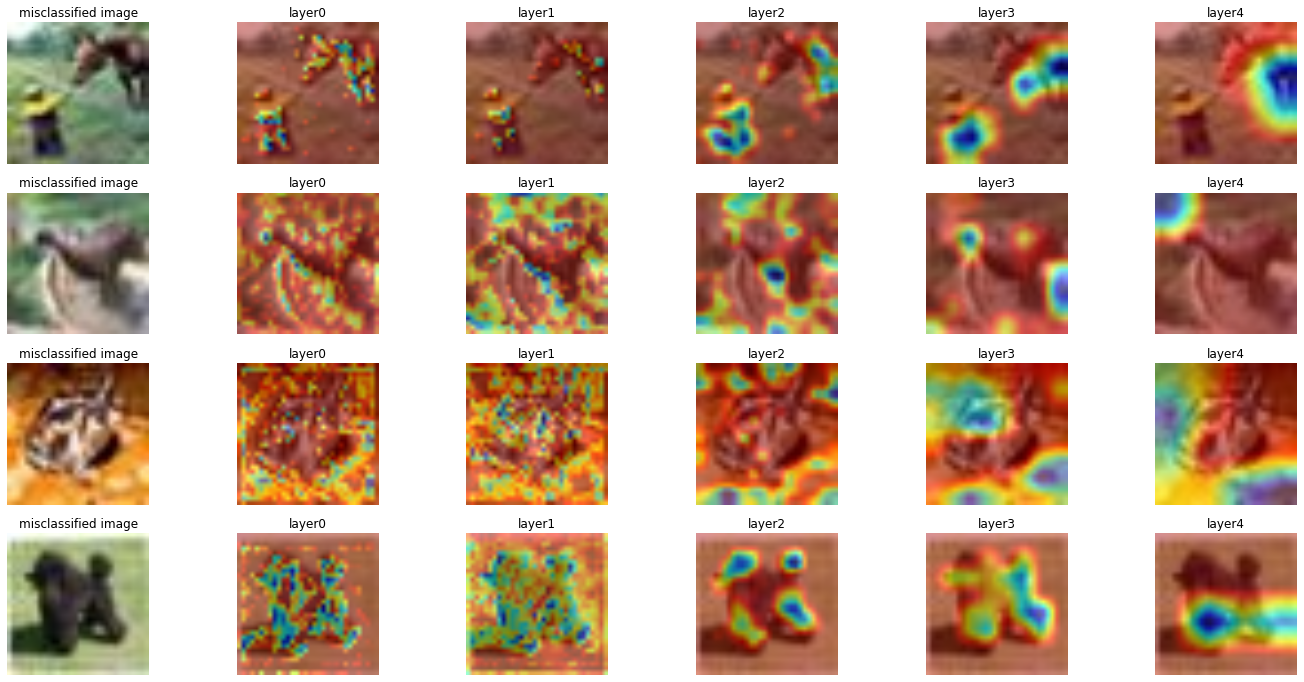

In [22]:
show_image(visualization, 0)

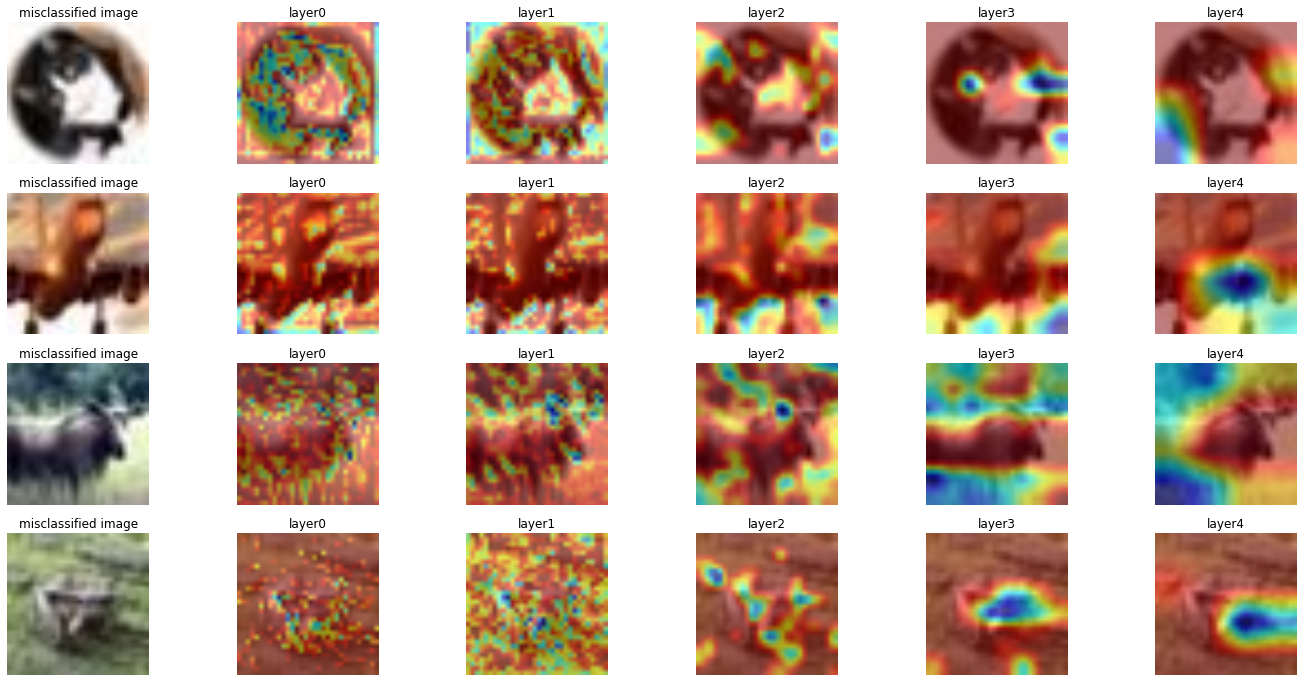

In [23]:
show_image(visualization, 24)

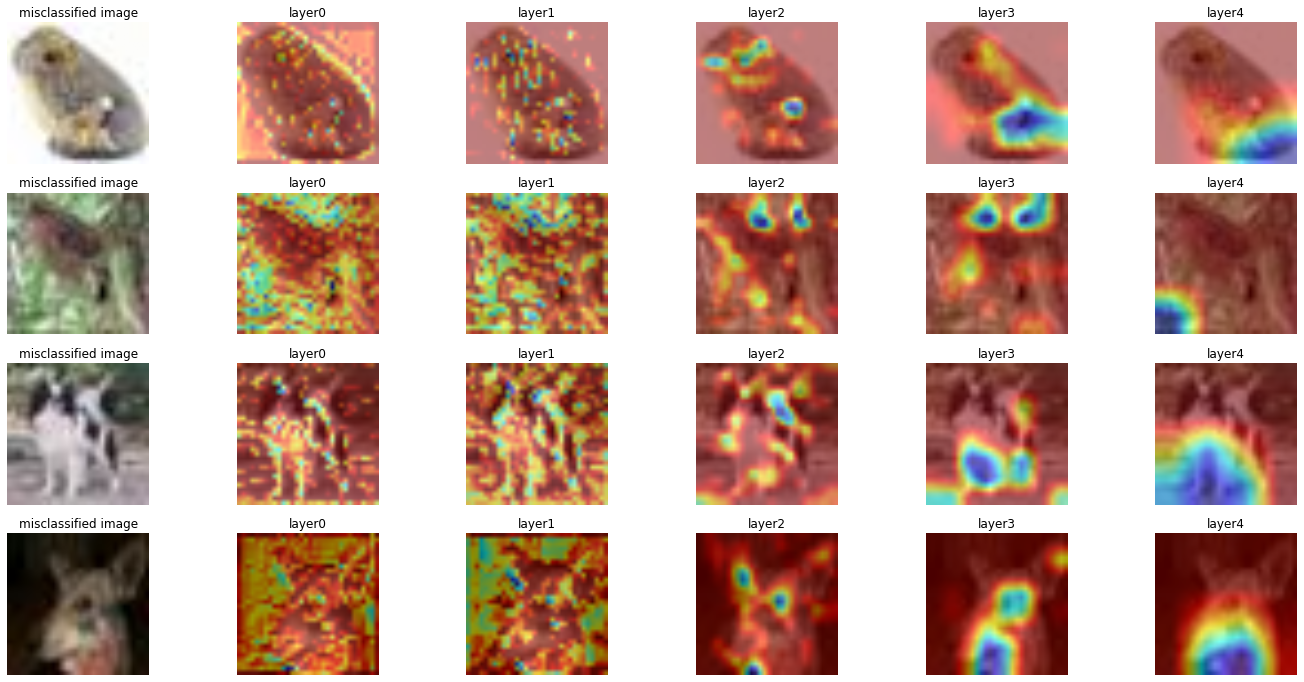

In [24]:
show_image(visualization, 48)

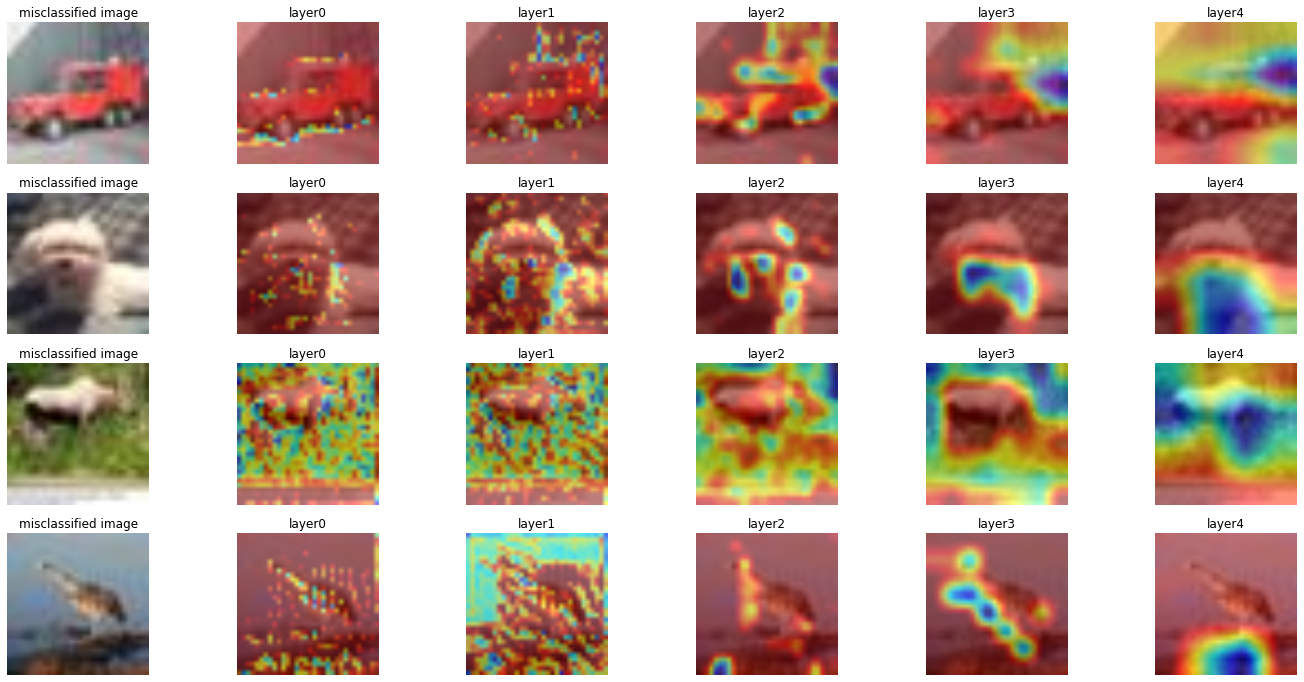

In [25]:
show_image(visualization, 72)

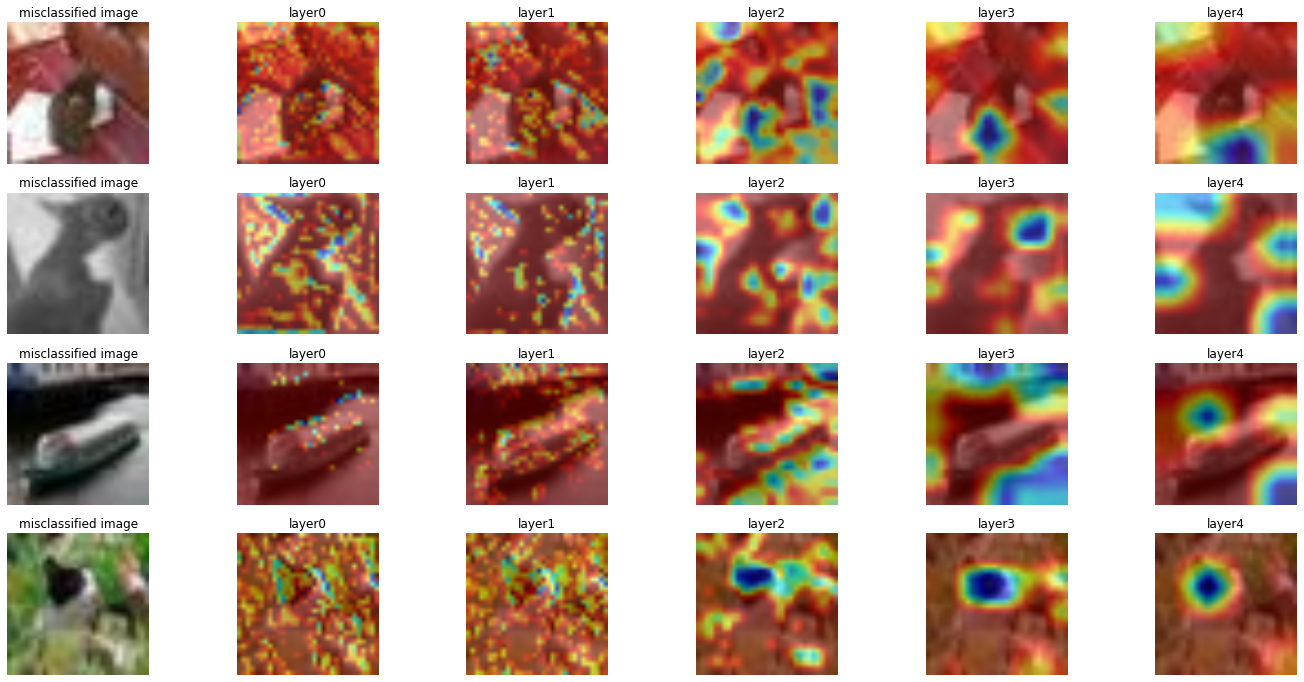

In [26]:
show_image(visualization, 96)

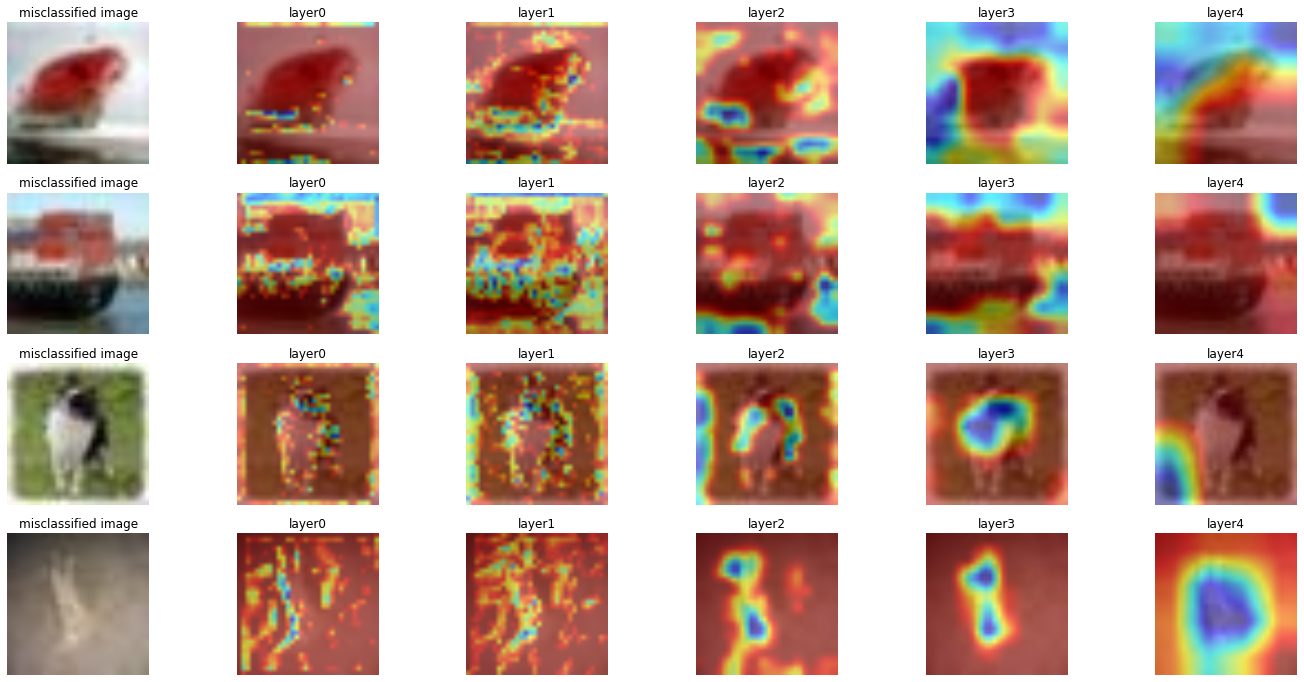

In [27]:
show_image(visualization, 120)